In [1]:
from sklearn.linear_model import LogisticRegression
from utils.dataset_wrapper import WrapperDataset
from ref.ActiveLearning_OG import AL
import matplotlib.pyplot as plt
from pipeline import GAL
import numpy as np
import wandb
import os

c:\Users\Saleem\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\Saleem\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
os.listdir('data')

['dataset_q1.pkl',
 'iris.pkl',
 'lab_dataset.pkl',
 'lab_dataset_2000.pkl',
 'wineQT.pkl']

In [14]:
def sample(dataset, train_size=None, pool_size=2_000, test_size=1_000):
	n_pool = len(dataset['available_pool_samples'])
	n_test = len(dataset['test_samples'])

	pool_sample_idx = np.random.choice(range(n_pool), pool_size)
	test_sample_idx = np.random.choice(range(n_test), test_size)

	dataset['available_pool_samples'] = dataset['available_pool_samples'][pool_sample_idx]
	dataset['available_pool_labels'] = dataset['available_pool_labels'][pool_sample_idx]

	dataset["test_samples"] = dataset["test_samples"][test_sample_idx]
	dataset["test_labels"] = dataset["test_labels"][test_sample_idx]

In [3]:
ds_name = 'lab_dataset_2000.pkl'
data_object = WrapperDataset(ds_name)
dataset = data_object.dataset
# sample(dataset)

input_dim = data_object.dim
output_dim = data_object.num_labels
labels = output_dim

In [4]:
dataset['available_pool_labels'].shape

(2000,)

In [6]:
iterations = 100
budg_per = 20
gnn_epochs = 20
quantile = .01
hidden_dim = 64
use_gnn = False

In [7]:
al = GAL(dataset,
		 LogisticRegression(),
		 budg_per,
		 uncertainty_measures=['entropy_e',
						 'density_kmean',
						 'pagerank',
						 'area_variance',],
		 # coef=[True, True, False, False],
		 iterations=iterations,
		 gnn_epochs=gnn_epochs,
		 quantile=quantile,
		 labels=labels,
		 input_dim=input_dim,
		 hidden_dim=hidden_dim,
		 output_dim=output_dim,
		 use_gnn=use_gnn,
		 train_graph_include_test=True,)

In [8]:
res_gal = al.run(plot=False)

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Saleem\AppData\Local\Programs\Python\Python312\Lib\site-packages\threadpoolctl.py:1186: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
100%|██████████| 100/100 [00:12<00:00,  7.79it/s, GAL_Iteration=99, GAL_Accuracy=0.703, GAL_LR test acc=0.703]


In [9]:
selection_criteria = ['random', 'custom']
accuracy_scores_dict = {}
for criterion in selection_criteria:
	AL_class = AL(dataset=dataset,
			   selection_criterion=criterion,
			   iterations=iterations,
			   budget_per_iter=budg_per,
			   train_limit=int(1e6))
	accuracy_scores_dict[criterion] = AL_class.run_pipeline()


Iteration 1/100
Accuracy: 0.551
----------------------------------------
Iteration 2/100
Accuracy: 0.593
----------------------------------------
Iteration 3/100
Accuracy: 0.641
----------------------------------------
Iteration 4/100
Accuracy: 0.68
----------------------------------------
Iteration 5/100
Accuracy: 0.679
----------------------------------------
Iteration 6/100
Accuracy: 0.679
----------------------------------------
Iteration 7/100
Accuracy: 0.692
----------------------------------------
Iteration 8/100
Accuracy: 0.684
----------------------------------------
Iteration 9/100
Accuracy: 0.689
----------------------------------------
Iteration 10/100
Accuracy: 0.699
----------------------------------------
Iteration 11/100
Accuracy: 0.705
----------------------------------------
Iteration 12/100
Accuracy: 0.702
----------------------------------------
Iteration 13/100
Accuracy: 0.703
----------------------------------------
Iteration 14/100
Accuracy: 0.704
---------------

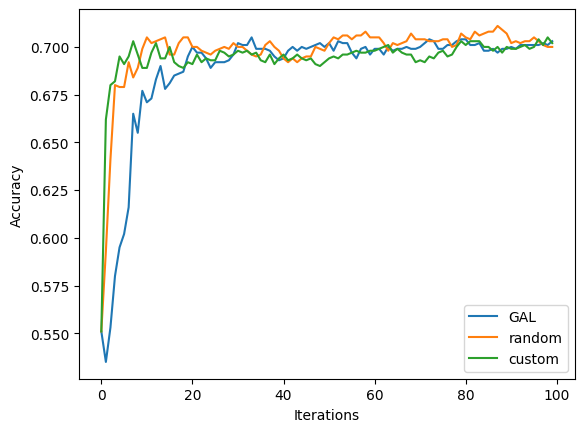

In [10]:
plt.plot(res_gal['aggr'], label='GAL')
if al.use_gnn:
	plt.plot(res_gal['GNN'], label='GNN', alpha=.5)
	plt.plot(res_gal['LR'], label='LR', alpha=.5)

for criterion, accuracy_scores in accuracy_scores_dict.items():
	plt.plot(accuracy_scores, label=criterion)
	# plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, label=criterion)

plt.xlabel('Iterations')
plt.ylabel('Accuracy')
# plt.xticks(range(1, len(accuracy_scores) + 1))
plt.legend()
plt.show()
